In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pylab as plt

from monteloanco import Model, GroupedBatchSampler

# Read model

In [3]:
model = Model(embedding_size=4, input_size=99858, device='cpu')
model.load_state_dict(torch.load('monteloanco.pt', weights_only=True))

<All keys matched successfully>

# Read data

In [4]:
df_jsonl = pd.read_json('accepted_2007_to_2018Q4.jsonl.gz', lines=True).set_index('id')

In [5]:
df = pd.read_csv('monteloanco.csv.gz', index_col='id')
df = df.join(df_jsonl, how='inner').reset_index()

In [6]:
df.installment = df.installment.apply(torch.tensor)
df.pymnt = df.pymnt.apply(torch.tensor)

# Perform test simulation

In [22]:
row = df.sample(1).squeeze()
print(row)
hidden_states, sim_pymnts, interst_payments, principal_payments = model.forward(
    batchidx=0,
    idx=torch.tensor(row.name).repeat(100), 
    installments=row.installment.repeat(100),
    loan_amnt=torch.tensor(row.loan_amnt).repeat(100), 
    int_rate=torch.tensor(row.int_rate).repeat(100))

id                                                      139179404
0                                                       -2.110538
1                                                       -0.763925
2                                                       -2.478365
3                                                        3.096994
pd                                                       0.000195
term_numeric                                                   36
installment                                      tensor(157.7500)
loan_amnt                                                    5000
int_rate                                                     8.46
pymnt           [tensor(157.7500), tensor(157.7500), tensor(15...
Name: 61863, dtype: object


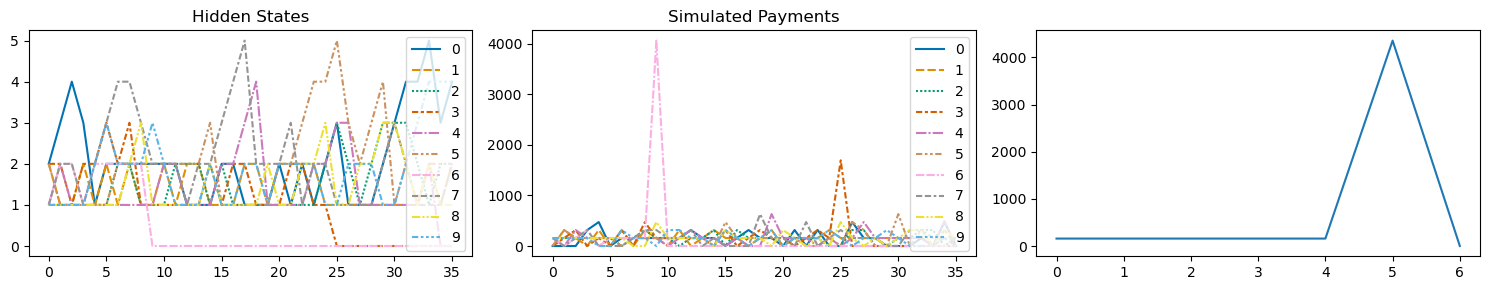

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(hidden_states.detach().numpy()[:,:10], ax=ax[0], palette='colorblind')
sns.lineplot(sim_pymnts.detach().numpy()[:,:10], ax=ax[1], palette='colorblind')
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

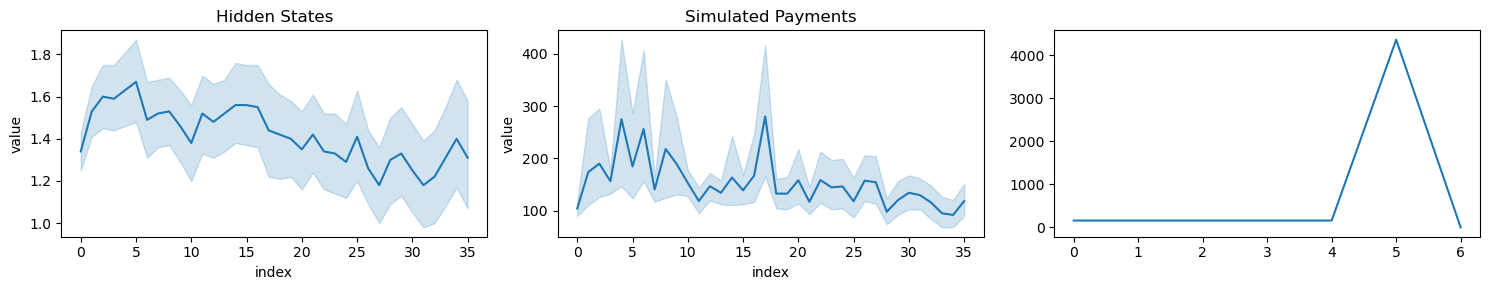

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(pd.DataFrame(hidden_states.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[0])
sns.lineplot(pd.DataFrame(sim_pymnts.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[1])
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

# Simulate full dataset

In [30]:
batch_size = 100_000
dataset = df[['id', 'installment', 'pymnt', 'loan_amnt', 'int_rate']].reset_index(names='idx').to_dict(orient='records')
grouped_batch_sampler = GroupedBatchSampler(dataset, batch_size)

In [31]:
from torch.utils.data import DataLoader

In [33]:
batches = [] 
for batchidx, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
    batches.append(model.forward(batchidx, batch['idx'], batch['installment'], batch['loan_amnt'], batch['int_rate'], batch['pymnt']))
hidden_states, sim_pymnts, interst_payments, principal_payments = zip(*batches)
#hidden_states = torch.concat(hidden_states, axis=-1)
#sim_pymnts = torch.concat(sim_pymnts, axis=-1)

In [34]:
from itertools import chain

s_sim_pymnts = pd.Series(torch.concat([x.sum(axis=0) for x in sim_pymnts]), index=chain.from_iterable(grouped_batch_sampler.batches))
s_sim_pymnts

0          570.809998
194      10366.129883
198        760.350037
205       2055.359863
219        509.489990
             ...     
97840    22887.724609
98010    19629.904297
98040    31018.519531
98367    21017.296875
99684    13695.962891
Length: 99858, dtype: float32

In [35]:
s_sim_pymnts.sum()

1258077700.0

# Score distributions

In [36]:
tmat = model._idx_to_tmat(
    torch.arange(dataset.__len__()), 
    batch_size=dataset.__len__())

In [37]:
def tmat_to_score(tmat):
    '''
    Function to identify probability of account being up to date after 12 months
    '''
    score = torch.zeros(8)
    score[1] = 1.
    for _ in range(12): score = torch.matmul(score, tmat)
    return score

scores = torch.vmap(tmat_to_score)(tmat)[(torch.arange(len(tmat)), 7)]

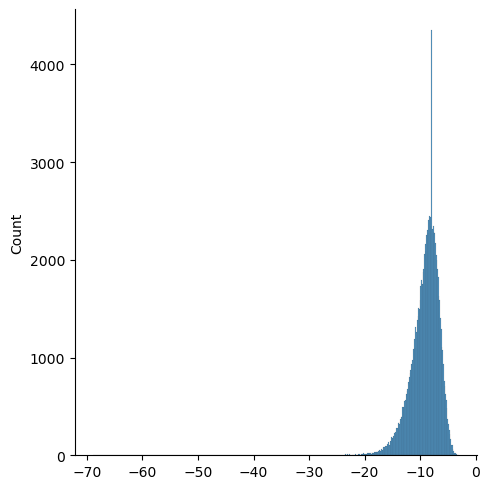

In [38]:
from scipy.special import logit

sns.displot(logit(scores.detach().numpy()), kind='hist')

In [39]:
df['pymnt_sum'] = [x.sum().item() for x in df.pymnt]
df['installment_sum'] = [x.sum().item() for x in df.installment]
df = df.join(s_sim_pymnts.rename('sim_pymnts_sum'))

In [40]:
df['pd_qcut'] = pd.qcut(df.pd, q=11)
df.groupby('pd_qcut', observed=False)[['pymnt_sum', 'installment_sum', 'sim_pymnts_sum']].sum()

,pymnt_sum,installment_sum,sim_pymnts_sum
pd_qcut,,,
"(-0.001, 3.43e-06]",1.016031e+08,4.072384e+06,109635608.0
"(3.43e-06, 1.45e-05]",9.911516e+07,4.076846e+06,108044672.0
"(1.45e-05, 3.62e-05]",1.056881e+08,4.090754e+06,112486184.0
"(3.62e-05, 7.39e-05]",1.087528e+08,4.097039e+06,114254864.0
"(7.39e-05, 0.000133]",1.091769e+08,4.000467e+06,112472256.0
"(0.000133, 0.000224]",1.109960e+08,4.039427e+06,114762960.0
"(0.000224, 0.000367]",1.124521e+08,4.045469e+06,116311880.0
"(0.000367, 0.000547]",1.123601e+08,3.979658e+06,119380040.0
"(0.000547, 0.000953]",1.132289e+08,4.034093e+06,116373040.0
